## Pre-processing the chosen geotiffs before passing to the stratification notebook

Checklist:
- all incoming data using same projection (and if not, reproject)
- align the spatial resolutions
- data cleaning - check for missing values
- normalise/ scale pixel values
- create data cube

some resources to check later:
https://discourse.pangeo.io/t/advice-for-scalable-raster-vector-extraction/4129

Adopt the python Builder pattern or pipeline pattern here to ensure robust pre-processing

In [227]:
%pip install pydantic -q

Note: you may need to restart the kernel to use updated packages.


In [228]:
import os
import warnings

import numpy as np
import xarray as xr
import geopandas as gpd

import matplotlib.pyplot as plt

import rasterio
from rasterio.warp import calculate_default_transform, reproject
from rasterio.enums import Resampling
import rioxarray
import rioxarray.merge

from rio_cogeo.cogeo import cog_translate
from rio_cogeo.profiles import cog_profiles

from typing import List

import logging

logging.basicConfig(level=logging.INFO,
                    format='%(asctime)s - %(levelname)s - %(message)s',
                    handlers=[
                        logging.FileHandler("debug.log"),
                        logging.StreamHandler()
                    ])

warnings.filterwarnings('ignore', message="The `squeeze` kwarg to GroupBy is being removed.*")

In [229]:
class RasterProcessor:
    def __init__(self, input_dir, output_dir, target_crs='EPSG:3857'):
        self.input_dir = input_dir
        self.output_dir = output_dir
        self.target_crs = target_crs
        self.data_arrays = self.load_rasters()
        self.filenames = self.get_filenames()
        self.num_rasters = len(self.data_arrays)
        self.finext_x_res = None
        self.finest_y_res = None
        self.finest_raster = self.find_finest_raster()

    def load_rasters(self):
        data_arrays = []
        for raster_file in os.listdir(self.input_dir):
            if raster_file.endswith('.tiff') or raster_file.endswith('.tif'):
                raster_path = os.path.join(self.input_dir, raster_file)
                # Open the raster file as an xarray DataArray with rioxarray
                data_array = rioxarray.open_rasterio(raster_path)
                data_arrays.append(data_array)
        return data_arrays
    
    def get_filenames(self):
        filenames = []
        for raster_file in os.listdir(self.input_dir):
            if raster_file.endswith('.tiff') or raster_file.endswith('.tif'):
                fpath = os.path.join(self.input_dir, raster_file)
                fname = os.path.basename(fpath)
                filenames.append(fname)
        return filenames

    def find_finest_raster(self):
        logging.info("Finding the finest raster in the dataset.")
        finest_res = float('inf')
        finest_raster = None
        
        for da in self.data_arrays:
            current_res = abs(da.rio.resolution()[0])
            if current_res < finest_res:
                finest_res = current_res
                finest_raster = da
        self.finest_raster = finest_raster
        logging.info(f"Finest raster found with resolution: {finest_res}")
        return self   

    def projection_check(self):
        reprojected_data_arrays = []
        logging.info(f"Checking CRS for {self.num_rasters} raster data arrays.")
        for da in self.data_arrays:
            if da.rio.crs != self.target_crs:
                logging.info(f"Reprojecting {da.rio.crs} to {self.target_crs}")
                reprojected_da = da.rio.reproject(self.target_crs)
                reprojected_data_arrays.append(reprojected_da)
            else:
                logging.info(f"Data array is already in the target CRS: {self.target_crs}")
                reprojected_data_arrays.append(da)
        self.data_arrays = reprojected_data_arrays
        return self
    

    def set_nodata(self):
        nodata_set_arrays = []
        logging.info(f"Setting NoData to NaN for {self.num_rasters} raster data arrays.")
        for da in self.data_arrays:
            original_nodata = da.rio.nodata
            input_da = da.astype("float32")
            # Replace original NoData with NaN in float32
            if original_nodata is not None:
                input_da = input_da.where(input_da != original_nodata, np.nan)
            
            input_da.rio.write_nodata(np.nan, inplace=True)
            input_da.rio.set_nodata(np.nan, inplace=True)
            nodata_set_arrays.append(input_da)
        self.data_arrays = nodata_set_arrays
        return self
    
    def validate_data(self):
        validated_data_arrays = []
        logging.info(f"Validating data for {self.num_rasters} raster data arrays.")
        for da in self.data_arrays:
            # Check for infinite values and replace them with NaN
            da = da.where(np.isfinite(da), np.nan)

            # Check for values too large for float64, although this is highly unlikely to exceed
            # the max float64 value in normal geospatial data scenarios.
            max_float64 = 1.797e+308
            da = da.where(da < max_float64, np.nan)

            validated_data_arrays.append(da)

        self.data_arrays = validated_data_arrays
        return self
    

    def resample_match(self):
        logging.info("Resampling all rasters to match the finest raster.")
        # because of small differences in coordinates dur to floating precision, also make sure to use assign_coords so all rasters have identical extents.
        resampled_data_arrays = []
        for da in self.data_arrays:
            if da is not self.finest_raster:
                # Reproject the data array to match the resolution of the finest data array
                resampled_da = da.rio.reproject_match(self.finest_raster)
                resampled_da = resampled_da.assign_coords(x=self.finest_raster.x, y=self.finest_raster.y)
                resampled_da = resampled_da.rio.interpolate_na(method="nearest")  # Ensure interpolation is the last step
                resampled_data_arrays.append(resampled_da)
            else:
                resampled_da = da.rio.interpolate_na(method="nearest")  # Apply also for the finest raster
                resampled_data_arrays.append(resampled_da)
        self.data_arrays = resampled_data_arrays
    
    def process(self):
        self.projection_check()
        self.validate_data()
        self.set_nodata()
        self.find_finest_raster()
        self.resample_match()
        return self
    
    def get_processed_data(self):
        return self.data_arrays
    

In [230]:
def save_as_cog(data_arrays, filenames, output_dir):

    for data_array, filename in zip(data_arrays, filenames):
        new_filename = filename.replace('.tif', '_processed.tif')
        output_path = os.path.join(output_dir, new_filename)  # Construct the full output path
        # Save using rio-cogeo
        data_array.rio.to_raster(output_path, driver='COG')

In [231]:
# class ResamplingMethods:
#     NEAREST = "nearest"
#     BILINEAR = "bilinear"
#     CUBIC = "cubic"

In [232]:
target_crs = 3857

input_raster_dir = "/workspace/notebooks/sandbox/data/stratification/input-rasters"
output_raster_dir = "/workspace/notebooks/sandbox/data/stratification/processed-rasters"


In [233]:
processor = RasterProcessor(input_raster_dir, output_raster_dir, target_crs='EPSG:3857')
processor.process()
processed_data_arrays = processor.get_processed_data()

save_as_cog(processed_data_arrays, processor.filenames, output_raster_dir)

2024-06-25 05:06:51,100 - INFO - Finding the finest raster in the dataset.
2024-06-25 05:06:51,102 - INFO - Finest raster found with resolution: 0.0002777013858103524
2024-06-25 05:06:51,103 - INFO - Checking CRS for 3 raster data arrays.
2024-06-25 05:06:51,104 - INFO - Reprojecting EPSG:4326 to EPSG:3857
2024-06-25 05:06:51,140 - INFO - Reprojecting EPSG:32750 to EPSG:3857
2024-06-25 05:06:51,206 - INFO - Reprojecting EPSG:4326 to EPSG:3857


2024-06-25 05:06:51,241 - INFO - Validating data for 3 raster data arrays.
2024-06-25 05:06:51,248 - INFO - Setting NoData to NaN for 3 raster data arrays.
/usr/local/lib/python3.10/site-packages/rioxarray/raster_writer.py:130: UserWarning: The nodata value (3.402823466e+38) has been automatically changed to (3.4028234663852886e+38) to match the dtype of the data.
  warnings.warn(
2024-06-25 05:06:51,255 - INFO - Finding the finest raster in the dataset.
2024-06-25 05:06:51,256 - INFO - Finest raster found with resolution: 22.960758636289807
2024-06-25 05:06:51,257 - INFO - Resampling all rasters to match the finest raster.


IndexError: index 2 is out of bounds for axis 0 with size 2

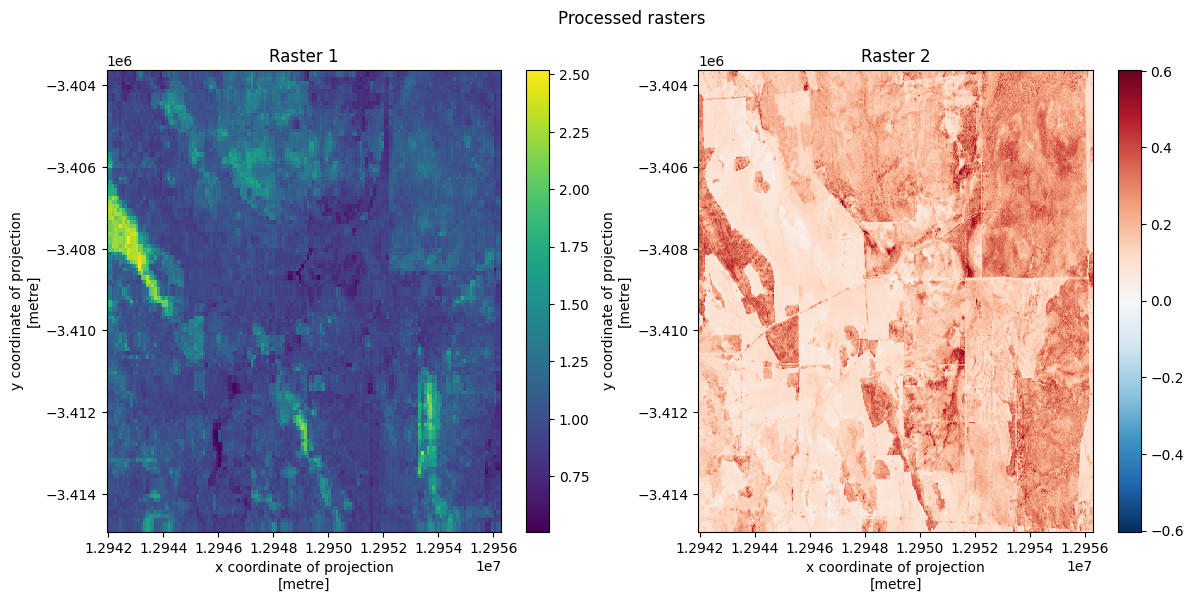

In [234]:
# n = len(processed_data_arrays)
# cols = 2
# rows = n // cols

# fig, axs = plt.subplots(rows, cols, figsize = (7 * cols, 6 * rows))
# fig.suptitle("Processed rasters")

# axs = axs.flatten()

# for i, raster in enumerate(processed_data_arrays):
#     raster.plot(ax = axs[i])
#     axs[i].set_title(f"Raster {i+1}")